In [25]:
import os
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import numpy as np
from datetime import datetime
from skimage import io
import random
import sys
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_fscore_support
#np.set_printoptions(threshold=sys.maxsize)

In [26]:
LIDCFilePath = "/storage/huybq/LIDC/"

SOURCE_DATA_HEATMAP64 = LIDCFilePath + "lidc_image/heatmap/heatmap_64/"

SOURCE_DATA_HEATMAP32 = LIDCFilePath + "lidc_image/heatmap/heatmap_32/"

SOURCE_DATA_GREY64 = LIDCFilePath + "lidc_image/grey/grey_64/"

SOURCE_DATA_GREY32 = LIDCFilePath + "lidc_image/grey/grey_32/"

BATCH_SIZE = 32

# INPUT_SHAPE = [None, IMAGE_SIZE, IMAGE_SIZE,CHANNELS]

OUTPUT_SHAPE = 3

MODEL_URL = "https://tfhub.dev/google/imagenet/inception_v3/classification/4"

metadata = pd.read_csv('/storage/huybq/LIDC/csvData/metadata.csv')
metadata32 = metadata.drop(metadata.loc[metadata['avail32'] == False].index)
metadata64 = metadata.drop(metadata.loc[metadata['avail64'] == False].index)

In [27]:
def get_quart(fileNames,texture):
    random.seed(datetime.now())
    quartFileName, tmp1, quartTexture, tmp2 = train_test_split(fileNames, 
                                                               texture, test_size=0.75,
                                                               random_state = 99)
    return quartFileName,quartTexture
def get_random_sample(class_data,index):
    random.seed(datetime.now())
    fileName_train = np.asarray([])
    texture_train = np.asarray([])
    fileName_valid = np.asarray([])
    texture_valid = np.asarray([])
    fileName_test = np.asarray([])
    texture_test = np.asarray([])
    sampleFileName_train, sampleFileName_valid, sampleTexture_train, sampleTexture_valid = train_test_split(class_data[:,0],
                                                                              class_data[:,1],
                                                                              test_size = 0.3,
                                                                              random_state=99)
    sampleFileName_valid, sampleFileName_test, sampleTexture_valid, sampleTexture_test = train_test_split(sampleFileName_valid,
                                                                              sampleTexture_valid,
                                                                              test_size = 0.333,
                                                                              random_state=99)
    #generate each image in trainset
    for i in range(sampleFileName_train.shape[0]):
        offsetFileName, offsetTexture = generator_with_offset(sampleFileName_train[i],sampleTexture_train[i])
        fileName_train = np.append(fileName_train,offsetFileName)
        texture_train = np.append(texture_train,offsetTexture)
    #generate each image in validset
    for i in range(sampleFileName_valid.shape[0]):
        offsetFileName, offsetTexture = generator_with_offset(sampleFileName_valid[i],sampleTexture_valid[i])
        fileName_valid = np.append(fileName_valid,offsetFileName)
        texture_valid = np.append(texture_valid,offsetTexture)
    #generate each image in validset
    for i in range(sampleFileName_test.shape[0]):
        offsetFileName, offsetTexture = generator_with_offset(sampleFileName_test[i],sampleTexture_test[i], test = True)
        fileName_test = np.append(fileName_test,offsetFileName)
        texture_test = np.append(texture_test,offsetTexture)
    if index == 2:
        fileName_train, texture_train = get_quart(fileName_train, texture_train)
        fileName_valid, texture_valid = get_quart(fileName_valid, texture_valid)
        fileName_test, texture_test = get_quart(fileName_test, texture_test)
    return fileName_train, fileName_valid, fileName_test, texture_train, texture_valid, texture_test

def get_boolen_texture(textures, classify = 'binary'):
    if classify == 'binary':
        unique_textures = np.asarray([1,2])
        textures[textures == 2] = 1
        textures[textures > 3] = 2
    else:
        unique_textures = np.asarray([1,2,3])
        textures[textures == 2] = 1
        textures[textures == 3] = 2
        textures[textures > 3] = 3
    return [texture == unique_textures for texture in textures]

def generator_with_offset(fileName, texture, test = False):
#     if test:
    offsetFileNames = np.asarray([fileName+'.png'])
    offsetTexture = np.repeat(texture,1)
#         return offsetFileNames,offsetTexture
#     if texture <= 3:
#         offsetFileNames = np.asarray([fileName+'.png',fileName+'_flip.png',fileName+'_rotate.png',fileName+'_flip_rotate.png'])
#         offsetTexture = np.repeat(texture,4)
#     else: 
#         offsetFileNames = np.asarray([fileName+'.png'])
#         offsetTexture = np.repeat(texture,1)
    return offsetFileNames,offsetTexture

def create_dataset(source_data):
    all_data = source_data[['fileName','texture']].to_numpy()
    all_data = all_data[np.argsort(all_data[:,1])]
    value, count = np.unique(all_data[:,1], return_counts=True)
    count = [count[0]+count[1],count[2],count[3]+count[4]]
    count = [count[0],count[0]+count[1],count[0]+count[1]+count[2]]
    
    data_by_class = np.split(all_data,count[0:2])
    
    fileName_train_multi = np.asarray([])
    texture_train_multi = np.asarray([])
    fileName_valid_multi = np.asarray([])
    texture_valid_multi = np.asarray([])
    fileName_test_multi = np.asarray([])
    texture_test_multi = np.asarray([])
    
    fileName_train_binary = np.asarray([])
    texture_train_binary = np.asarray([])
    fileName_valid_binary = np.asarray([])
    texture_valid_binary = np.asarray([])
    fileName_test_binary = np.asarray([])
    texture_test_binary = np.asarray([])
    
    for index,data in enumerate(data_by_class):
        testName_train, testName_valid, testName_test, testTexture_train, testTexture_valid, testTexture_test = get_random_sample(data,index)
        #append train, valid, test data
        if index != 1:
            fileName_train_binary = np.append(fileName_train_binary,testName_train)
            texture_train_binary = np.append(texture_train_binary,testTexture_train)
            fileName_valid_binary = np.append(fileName_valid_binary,testName_valid)
            texture_valid_binary = np.append(texture_valid_binary,testTexture_valid)
            fileName_test_binary = np.append(fileName_test_binary,testName_test)
            texture_test_binary = np.append(texture_test_binary,testTexture_test)
            
        fileName_train_multi = np.append(fileName_train_multi,testName_train)
        texture_train_multi = np.append(texture_train_multi,testTexture_train)
        fileName_valid_multi = np.append(fileName_valid_multi,testName_valid)
        texture_valid_multi = np.append(texture_valid_multi,testTexture_valid)
        fileName_test_multi = np.append(fileName_test_multi,testName_test)
        texture_test_multi = np.append(texture_test_multi,testTexture_test)
    return [fileName_train_multi, fileName_valid_multi, fileName_test_multi, get_boolen_texture(texture_train_multi,classify = 'multi'), get_boolen_texture(texture_valid_multi,classify = 'multi'), get_boolen_texture(texture_test_multi,classify = 'multi')],\
            [fileName_train_binary, fileName_valid_binary, fileName_test_binary, get_boolen_texture(texture_train_binary,classify = 'binary'), get_boolen_texture(texture_valid_binary,classify = 'binary'), get_boolen_texture(texture_test_binary,classify = 'binary')]

In [28]:
def process_image(filePath):
    image = tf.io.read_file(filePath)
    image = tf.io.decode_png(image,channels = 0)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image,(224,224))
    return image
def get_image_label(filePath,texture):
    image = process_image(filePath)
    return image,texture

In [29]:
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
    if test_data:
        print("Creating test data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X),tf.constant(y)))
        data_batch = data.map(get_image_label).batch(BATCH_SIZE)
        return data_batch
    if valid_data:
        print("Creating validation data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X),tf.constant(y)))
        data_batch = data.map(get_image_label).batch(BATCH_SIZE)
        return data_batch
    print("Creating training data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),tf.constant(y)))
    data = data.shuffle(buffer_size=len(X))
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

In [30]:
def create_model(inputShape, outputShape, classify = 'binary', transfer = False):
    #parameter
    outputActivation = 'sigmoid' if classify == 'binary' else 'softmax'
    LOSS = tf.keras.losses.BinaryCrossentropy() if classify == 'binary' else tf.keras.losses.CategoricalCrossentropy()
    METRICS = [tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.Precision(),tf.keras.metrics.Recall()] if classify == 'binary' else [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(),tf.keras.metrics.Recall()]
    if transfer:
         model = tf.keras.Sequential([
             hub.KerasLayer("https://tfhub.dev/google/imagenet/inception_v3/classification/4"),
             tf.keras.layers.Dense(units=outputShape,activation=outputActivation)
         ])
    else:
    #model
        model = tf.keras.Sequential([
            #layer 1
            tf.keras.layers.Conv2D(32,5,strides = 1,padding = "same",input_shape = inputShape[1:] , data_format = 'channels_last',activation='relu'),
            tf.keras.layers.Conv2D(32,5,strides = 1,padding = "same", data_format = 'channels_last',activation='relu'),
            tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2, padding = "valid" ,data_format='channels_last'),
            #layer 2
            tf.keras.layers.Conv2D(64,3,strides = 1,padding = "same", data_format = 'channels_last',activation='relu'),
            tf.keras.layers.Conv2D(64,3,strides = 1,padding = "same", data_format = 'channels_last',activation='relu'),
            tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2, padding = "valid" ,data_format='channels_last'),
            #layer 3
            tf.keras.layers.Conv2D(128,1,strides = 1,padding = "same", data_format = 'channels_last',activation='relu'),
            tf.keras.layers.Conv2D(128,1,strides = 1,padding = "same", data_format = 'channels_last',activation='relu'),
            tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2, padding = "same" ,data_format='channels_last'),
            #layer 4
            tf.keras.layers.Conv2D(256,3,strides = 1,padding = "same", data_format = 'channels_last',activation='relu'),
            tf.keras.layers.Conv2D(256,3,strides = 1,padding = "same", data_format = 'channels_last',activation='relu'),
            tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2, padding = "valid" ,data_format='channels_last'),
            #layer 5
            tf.keras.layers.Conv2D(512,3,strides = 1,padding = "same", data_format = 'channels_last',activation='relu'),
            tf.keras.layers.Conv2D(512,3,strides = 1,padding = "same", data_format = 'channels_last',activation='relu'),
            tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2, padding = "valid" ,data_format='channels_last'),

            tf.keras.layers.Flatten(),
            #last layer
            tf.keras.layers.Dense(units=128,activation='relu'),
            tf.keras.layers.Dense(units=outputShape,activation=outputActivation)
        ])
    model.compile(
      loss=LOSS,
      optimizer=tf.keras.optimizers.Adam(1e-05),
      metrics=METRICS
    )
    model.build(inputShape)
    return model

In [31]:
model = create_model([None,64,64,3],3,'multi')
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 128)      

In [32]:
early_stopping_multi = tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy',
                                                  patience=10,
                                                  restore_best_weights = True)
learning_rate_reduce_multi = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy',
                                                            patience=3,
                                                            factor=0.02,
                                                            min_lr=1e-08)
early_stopping_binary = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy',
                                                  patience=10,
                                                  restore_best_weights = True)
learning_rate_reduce_binary = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_binary_accuracy',
                                                            patience=3,
                                                            factor=0.02,
                                                            min_lr=1e-08)

In [33]:
#strategy = tf.distribute.MirroredStrategy()
NUM_EPOCHS = 100
[X_train_multi, X_valid_multi, X_test_multi, y_train_multi, y_valid_multi, y_test_multi],[X_train_binary, X_valid_binary, X_test_binary, y_train_binary, y_valid_binary, y_test_binary] = create_dataset(metadata32)

In [34]:
def add_source(fileNames):
    print(len(fileNames))
    sourceNames = np.asarray([])
    for fileName in fileNames:
        sourceNames = np.append(sourceNames, SOURCE_DATA_HEATMAP32 + fileName)
    return sourceNames
train_data_multi = create_data_batches(add_source(X_train_multi), y_train_multi)
valid_data_multi = create_data_batches(add_source(X_valid_multi), y_valid_multi, valid_data = True)
test_data_multi = create_data_batches(add_source(X_test_multi), y_test_multi, test_data = True)

train_data_binary = create_data_batches(add_source(X_train_binary), y_train_binary)
valid_data_binary = create_data_batches(add_source(X_valid_binary), y_valid_binary, valid_data = True)
test_data_binary = create_data_batches(add_source(X_test_binary), y_test_binary, test_data = True)

850
Creating training data batches...
243
Creating validation data batches...
123
Creating test data batches...
667
Creating training data batches...
191
Creating validation data batches...
96
Creating test data batches...


In [35]:
def train_model(classify = 'binary'):
    train_data = train_data_binary if classify == 'binary' else train_data_multi
    valid_data = valid_data_binary if classify == 'binary' else valid_data_multi
    outputShape = 2 if classify == 'binary' else 3
    callBacks = [early_stopping_binary,learning_rate_reduce_binary] if classify == 'binary' else [early_stopping_multi,learning_rate_reduce_multi]
    model = create_model([None,224,224,3],outputShape,classify,transfer=True)
    #tensorboard = tf.keras.callbacks.TensorBoard(logdir)
    model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=valid_data,
            validation_freq=1,
            callbacks=callBacks
             )
    return model

In [36]:
model_multi = train_model('multi')
model_binary = train_model('binary')

Epoch 1/100
27/27 [==============================] - 13s 484ms/step - loss: 2.0864 - categorical_accuracy: 0.3118 - precision_5: 0.3099 - recall_5: 0.2753 - val_loss: 0.0000e+00 - val_categorical_accuracy: 0.0000e+00 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00
Epoch 2/100
27/27 [==============================] - 6s 233ms/step - loss: 2.0121 - categorical_accuracy: 0.3200 - precision_5: 0.3160 - recall_5: 0.2788 - val_loss: 2.0390 - val_categorical_accuracy: 0.3416 - val_precision_5: 0.3408 - val_recall_5: 0.3128
Epoch 3/100
27/27 [==============================] - 6s 227ms/step - loss: 1.9395 - categorical_accuracy: 0.3271 - precision_5: 0.3320 - recall_5: 0.2965 - val_loss: 1.9701 - val_categorical_accuracy: 0.3416 - val_precision_5: 0.3484 - val_recall_5: 0.3169
Epoch 4/100
27/27 [==============================] - 6s 227ms/step - loss: 1.8816 - categorical_accuracy: 0.3376 - precision_5: 0.3433 - recall_5: 0.3094 - val_loss: 1.9111 - val_categorical_accuracy: 0.3333 - va

In [37]:
predict_multi = model_multi.predict(test_data_multi, verbose = 1)
predict_binary = model_binary.predict(test_data_binary, verbose = 1)

3/3 [==============================] - 1s 420ms/step


In [38]:
def get_pred_label(prediction_probabilities, classify = 'binary'):
    unique_textures = np.asarray([1,2]) if classify == 'binary' else np.asarray([1,2,3])
    predict_labels = []
    for prediction_probability in prediction_probabilities:
        predict_labels.append(unique_textures[np.argmax(prediction_probability)])
    return np.asarray(predict_labels)
def unbatchify(data, classify = 'binary'):
    unique_textures = np.asarray([1,2]) if classify == 'binary' else np.asarray([1,2,3])
    labels = []
    for image, label in data.unbatch():
        labels.append(unique_textures[np.argmax(label)])
    return np.asarray(labels)

[Text(0, 0.5, 'Non-solid'), Text(0, 1.5, 'Part-solid'), Text(0, 2.5, 'Solid')]

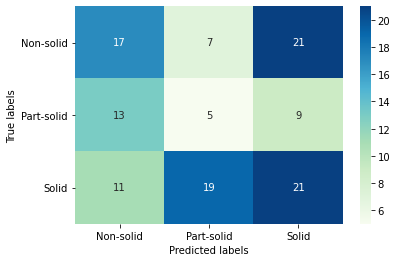

In [42]:
test_labels_multi = unbatchify(test_data_multi,'multi')
test_labels_binary = unbatchify(test_data_binary)
predict_labels_multi = get_pred_label(predict_multi,'multi')
predict_labels_binary = get_pred_label(predict_binary)
# df = pd.DataFrame(classification_report(test_labels_multi,predict_labels_multi,target_names=['Non-solid','Part-solid','Solid'],output_dict = True,zero_division=1))
# df = df.drop(columns=['macro avg','weighted avg'])
# df['accuracy'][0:3]=np.NaN
# df = df.rename({'support':"samples"})
# classificationReport = sns.heatmap(df.T, annot=True, vmin = 0, vmax = 1, fmt=".3f", cmap='GnBu',square = True, robust= True)
# classificationReport.set_yticklabels(classificationReport.get_yticklabels(), rotation=0, ha="right")

cfm_acc = sns.heatmap(confusion_matrix(test_labels_multi,predict_labels_multi), annot=True, fmt='d', cmap='GnBu')
cfm_acc.set_xlabel('Predicted labels')
cfm_acc.set_ylabel('True labels')
cfm_acc.xaxis.set_ticklabels(['Non-solid','Part-solid','Solid'])
cfm_acc.yaxis.set_ticklabels(['Non-solid','Part-solid','Solid'])
cfm_acc.set_yticklabels(cfm_acc.get_yticklabels(), rotation=0, ha="right")

In [77]:
record_multi = pd.DataFrame(np.asarray([test_labels_multi,predict_labels_multi]).T,columns=["y_test","y_pred"])
record_multi.to_csv("/storage/huybq/LIDC/csvData/balanced/heatmap/heatmap_64/record3_multi.csv")
# np.asarray([test_labels_multi,predict_labels_multi]).T
record_binary = pd.DataFrame(np.asarray([test_labels_binary,predict_labels_binary]).T,columns=["y_test","y_pred"])
record_binary.to_csv("/storage/huybq/LIDC/csvData/balanced/heatmap/heatmap_64/record3_binary.csv")

In [87]:
record_multi = pd.DataFrame(np.asarray([test_labels_multi,predict_labels_multi]).T,columns=["y_test","y_pred"])
record_multi.to_csv("/storage/huybq/LIDC/csvData/balanced/grey/grey_64/record3_multi.csv")
# np.asarray([test_labels_multi,predict_labels_multi]).T
record_binary = pd.DataFrame(np.asarray([test_labels_binary,predict_labels_binary]).T,columns=["y_test","y_pred"])
record_binary.to_csv("/storage/huybq/LIDC/csvData/balanced/grey/grey_64/record3_binary.csv")

In [21]:
def resultGenerator(test_labels, predict_labels, scenario, dataType, case, index,classify = 'binary'):
    print(precision_recall_fscore_support(test_labels,predict_labels,zero_division=1,average = 'weighted'),classify)
    labels = ['Non-solid','Solid'] if classify == 'binary' else ['Non-solid','Part-solid','Solid']
    df = pd.DataFrame(classification_report(test_labels,predict_labels,target_names=labels,output_dict = True,zero_division=1))
    df = df.drop(columns=['macro avg','weighted avg'])
    df['accuracy'][0:3]=np.NaN
    df = df.rename({'support':"samples"})
    classificationReport = sns.heatmap(df.T, annot=True, vmin = 0, vmax = 1, fmt=".3f", cmap='GnBu',square = True, robust= True)
    classificationReport.set_yticklabels(classificationReport.get_yticklabels(), rotation=0, ha="right")
#     plt.savefig(f"/storage/huybq/LIDC/figure/{scenario}/{dataType}/{dataType}{case}/result{index}_classificationReport_{classify}.png",dpi=360,bbox_inches='tight')
#     plt.clf()
#     cfm_acc = sns.heatmap(confusion_matrix(test_labels,predict_labels,nomalize=[]), annot=True, fmt='d', cmap='GnBu')
#     cfm_acc.set_xlabel('Predicted labels')
#     cfm_acc.set_ylabel('True labels')
#     cfm_acc.xaxis.set_ticklabels(labels)
#     cfm_acc.yaxis.set_ticklabels(labels)
#     cfm_acc.set_yticklabels(cfm_acc.get_yticklabels(), rotation=0, ha="right")
#     plt.savefig(f"/storage/huybq/LIDC/figure/{scenario}/{dataType}/{dataType}{case}/result{index}_confusionMatrix_{classify}.png",dpi=360,bbox_inches='tight')

In [19]:
plt.cla()
plt.clf()
plt.close()
#define scenario
scenarios = ['augmented','balanced']
#define data type
dataTypes = ['heatmap','grey']
#define case
cases = [64,32]
#define index
test_labels_multi = np.asarray([])
predict_labels_multi = np.asarray([])
test_labels_binary = np.asarray([])
predict_labels_binary = np.asarray([])
for scenario in scenarios:
    for dataType in dataTypes:
        for case in cases:
            for index in range(1,4): 
                print(scenario, dataType, case, index)
                record_multi = pd.read_csv(f"/storage/huybq/LIDC/csvData/{scenario}/{dataType}/{dataType}_{case}/record{index}_multi.csv")
                record_binary = pd.read_csv(f"/storage/huybq/LIDC/csvData/{scenario}/{dataType}/{dataType}_{case}/record{index}_binary.csv")
#                 test_labels_multi= np.append(test_labels_multi,record_multi['y_test'].to_numpy())
#                 predict_labels_multi= np.append(predict_labels_multi,record_multi['y_pred'].to_numpy())
#                 test_labels_binary= np.append(test_labels_binary,record_binary['y_test'].to_numpy())
#                 predict_labels_binary= np.append(predict_labels_binary,record_binary['y_pred'].to_numpy())
                test_labels_multi = record_multi['y_test']
                predict_labels_multi = record_multi['y_pred']
                test_labels_binary = record_binary['y_test']
                predict_labels_binary = record_binary['y_pred']
                resultGenerator(test_labels_multi, predict_labels_multi, scenario, dataType, case, index ,'multi')
                resultGenerator(test_labels_binary, predict_labels_binary, scenario, dataType, case, index ,'binary')
# record_multi = pd.read_csv(f"/storage/huybq/LIDC/csvData/{scenario}/{dataType}/{dataType}_{case}/record{index}_multi.csv")
# record_binary = pd.read_csv(f"/storage/huybq/LIDC/csvData/{scenario}/{dataType}/{dataType}_{case}/record{index}_binary.csv")

# test_labels_multi = record_multi['y_test']
# predict_labels_multi = record_multi['y_pred']
# test_labels_binary = record_binary['y_test']
# predict_labels_binary = record_binary['y_pred']
# resultGenerator(test_labels_multi, predict_labels_multi, scenario, dataType, case, 3,'multi')
# resultGenerator(test_labels_binary, predict_labels_binary, scenario, dataType, case, 3,'binary')

augmented heatmap 64 1
(0.7965103513410272, 0.7830188679245284, 0.7833327546439128, None) multi
(0.9000190694126621, 0.8768115942028986, 0.8832109919066441, None) binary
augmented heatmap 64 2
(0.8144199439266501, 0.7924528301886793, 0.7966758668536869, None) multi
(0.9099119282680884, 0.894927536231884, 0.8992783830409946, None) binary
augmented heatmap 64 3
(0.8015310125357374, 0.7830188679245284, 0.7865157580301873, None) multi
(0.9066742944317315, 0.8840579710144928, 0.8900809335591944, None) binary
augmented heatmap 32 1
(0.7824210113900315, 0.7328519855595668, 0.743827880001458, None) multi
(0.8842709890628689, 0.84, 0.8525143678160919, None) binary
augmented heatmap 32 2
(0.7730280508856295, 0.7725631768953068, 0.7602863109912658, None) multi
(0.8827295248104496, 0.824, 0.8396322317633792, None) binary
augmented heatmap 32 3
(0.7792657003060346, 0.779783393501805, 0.774319232759279, None) multi
(0.8802786452077828, 0.84, 0.8518680119989092, None) binary
augmented grey 64 1
(0.79